# Getaround Rental Delay Analysis

The goal of this analysis is to help the Product Team define the optimal minimum delay between two consecutive rentals.

Late checkouts generate friction for the next driver and negatively impact user experience. However, introducing a minimum delay between rentals may reduce the number of bookings and therefore impact revenue.

This notebook aims to quantify the trade-off between:

- Customer satisfaction
- Operational reliability
- Owner revenue

We will simulate different delay thresholds in order to support product decision-making.

## Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="whitegrid")

## Data Loading

In [3]:
df = pd.read_excel("../data/get_around_delay_analysis.xlsx")

df.head()

,rental_id,car_id,checkin_type,state,delay_at_checkout_in_minutes,previous_ended_rental_id,time_delta_with_previous_rental_in_minutes
0,505000,363965,mobile,canceled,NaN,NaN,NaN
1,507750,269550,mobile,ended,-81.0,NaN,NaN
2,508131,359049,connect,ended,70.0,NaN,NaN
3,508865,299063,connect,canceled,NaN,NaN,NaN
4,511440,313932,mobile,ended,NaN,NaN,NaN


In [4]:
df.columns

Index(['rental_id', 'car_id', 'checkin_type', 'state',
       'delay_at_checkout_in_minutes', 'previous_ended_rental_id',
       'time_delta_with_previous_rental_in_minutes'],
      dtype='object')

In [5]:
print("Number of rows : {}".format(df.shape[0]))
print()

print(" Basic statistics: ")
display(df.describe(include='all'))


print("Percentage of missing values : ")
display(100*df.isnull().sum()/df.shape[0])

Number of rows : 21310

 Basic statistics: 


,rental_id,car_id,checkin_type,state,delay_at_checkout_in_minutes,previous_ended_rental_id,time_delta_with_previous_rental_in_minutes
count,21310.000000,21310.000000,21310,21310,16346.000000,1841.000000,1841.000000
unique,NaN,NaN,2,2,NaN,NaN,NaN
top,NaN,NaN,mobile,ended,NaN,NaN,NaN
freq,NaN,NaN,17003,18045,NaN,NaN,NaN
mean,549712.880338,350030.603426,NaN,NaN,59.701517,550127.411733,279.288430
std,13863.446964,58206.249765,NaN,NaN,1002.561635,13184.023111,254.594486
min,504806.000000,159250.000000,NaN,NaN,-22433.000000,505628.000000,0.000000
25%,540613.250000,317639.000000,NaN,NaN,-36.000000,540896.000000,60.000000
50%,550350.000000,368717.000000,NaN,NaN,9.000000,550567.000000,180.000000
75%,560468.500000,394928.000000,NaN,NaN,67.000000,560823.000000,540.000000


Percentage of missing values : 


rental_id                                      0.000000
car_id                                         0.000000
checkin_type                                   0.000000
state                                          0.000000
delay_at_checkout_in_minutes                  23.294228
previous_ended_rental_id                      91.360863
time_delta_with_previous_rental_in_minutes    91.360863
dtype: float64

## Data Preparation

In this section, we prepare the dataset for delay analysis.

We restrict our analysis to completed rentals and handle missing values in delay-related variables in order to reflect real operational situations.

In [6]:
df_clean = df.copy()

# Keep only completed rentals
df_clean = df_clean[df_clean["state"] == "ended"]

# Replace missing delays by 0 (means on-time return)
df_clean["delay_at_checkout_in_minutes"] = (
    df_clean["delay_at_checkout_in_minutes"]
    .fillna(0)
)

df_clean.shape

(18045, 7)

## Exploratory Data Analysis

Before analyzing late checkouts, we explore the structure of rentals and their scheduling patterns.

Understanding how rentals are distributed across check-in types and how frequently cars are booked consecutively will help assess the structural risk of operational conflicts.

In [25]:
checkin_counts = df_clean["checkin_type"].value_counts(normalize=True)

checkin_counts

checkin_type
mobile     0.805542
connect    0.194458
Name: proportion, dtype: float64

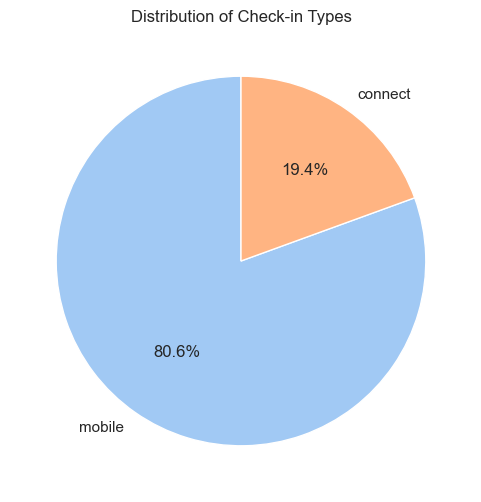

In [26]:
plt.figure(figsize=(6, 6))
plt.pie(
    checkin_counts,
    labels=checkin_counts.index,
    autopct="%1.1f%%",
    startangle=90,
    colors=sns.color_palette("pastel")
)
plt.title("Distribution of Check-in Types")
plt.show()


### Interpretation

Most rentals are completed through the mobile check-in process, representing approximately 80% of all completed bookings.

Connect rentals account for a smaller share of the platform usage. However, since Connect enables fully remote access to the vehicle, delays in this segment may generate more operational friction compared to mobile check-ins that require a physical handoff between users.

In [29]:
consecutive_rental_exposure_rate = (
    df_clean["time_delta_with_previous_rental_in_minutes"]
    .notna()
    .mean()
)

print(f"{consecutive_rental_exposure_rate:.2%}")

8.93%


### Interpretation

Approximately 9% of completed rentals are followed by another booking on the same vehicle.

These rentals are operationally exposed to potential scheduling conflicts in case of a late checkout. In contrast, the remaining 91% of rentals are isolated and would not impact another user if returned late.

This suggests that introducing a minimum delay between consecutive rentals would primarily affect a limited portion of bookings while potentially improving operational reliability for tightly scheduled vehicles.

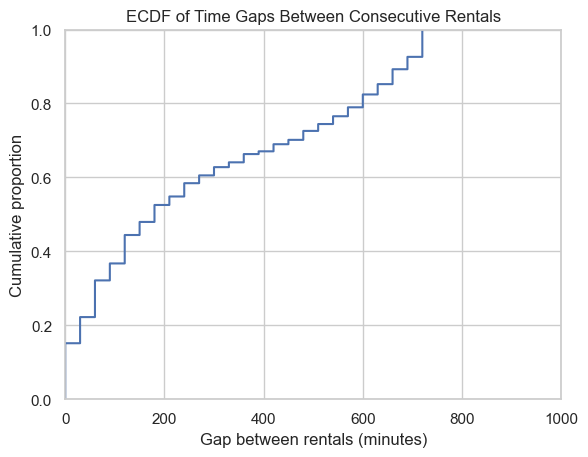

In [28]:
gaps = df_clean[
    "time_delta_with_previous_rental_in_minutes"
].dropna()

sns.ecdfplot(gaps)

plt.xlim(0, 1000)

plt.xlabel("Gap between rentals (minutes)")
plt.ylabel("Cumulative proportion")
plt.title("ECDF of Time Gaps Between Consecutive Rentals")

plt.show()

### Interpretation

Among consecutive rentals, time gaps between bookings vary significantly.

While some rentals are scheduled several hours apart, a substantial proportion are separated by less than three hours. These short gaps increase the likelihood that a late checkout may interfere with the next driver’s scheduled pickup.

## Late Checkout Analysis

We first evaluate how frequently drivers return cars late at checkout.

Understanding the proportion of late returns is essential to estimate the operational risk for subsequent rentals.

In [8]:
df_clean["is_late"] = (
    df_clean["delay_at_checkout_in_minutes"] > 0
)

late_rate = df_clean["is_late"].mean()
print(f"Late checkout rate: {late_rate:.2%}")


Late checkout rate: 52.11%


### Interpretation

Approximately 52% of completed rentals are returned later than initially scheduled.

This indicates that late checkouts are not isolated incidents but occur in a significant proportion of bookings. While not all delays necessarily impact subsequent rentals, this level of lateness represents a potential source of operational disruption when vehicles are scheduled for consecutive use.

These findings highlight the need for a scheduling buffer between rentals in order to protect the experience of the next driver.

## Magnitude of Late Returns

We now focus only on late checkouts to better understand the operational impact of delays.

This allows us to distinguish between minor delays and significant disruptions that may affect the next rental.

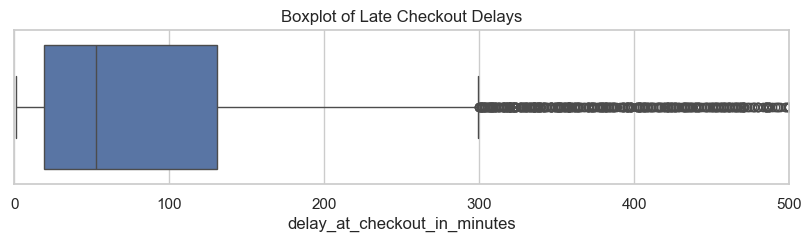

In [18]:
late_delays = df_clean[
    df_clean["delay_at_checkout_in_minutes"] > 0
]["delay_at_checkout_in_minutes"]


plt.figure(figsize=(10, 2))

sns.boxplot(
    x=late_delays
)

plt.xlim(0, 500)

plt.title("Boxplot of Late Checkout Delays")

plt.show()

### Interpretation

More than half of completed rentals are returned late.

Among late returns, the median delay is around 30 to 40 minutes, which represents a significant operational risk when two rentals are scheduled on the same day.

While some delays are minor, a large proportion of late checkouts exceed one hour, potentially creating friction for the next driver and negatively impacting customer experience.

These results suggest that introducing a minimum delay between rentals could help mitigate operational issues, but the appropriate threshold still needs to be evaluated in order to balance reliability and revenue.

## Cumulative Distribution of Late Checkout Delays

We analyze the cumulative distribution of late checkout delays to estimate the proportion of delays that would be absorbed by different minimum delay thresholds.

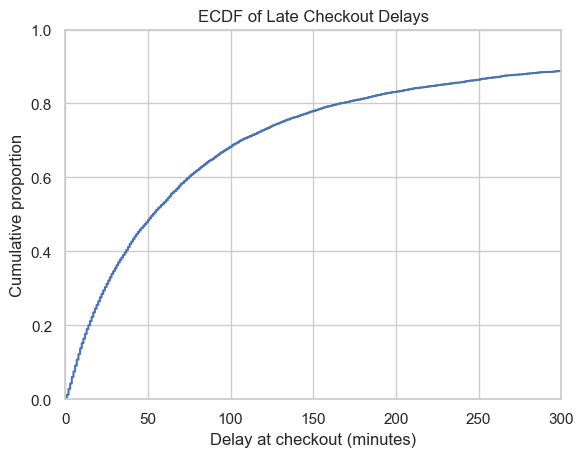

In [19]:
sns.ecdfplot(late_delays)

plt.xlim(0, 300)

plt.xlabel("Delay at checkout (minutes)")
plt.ylabel("Cumulative proportion")
plt.title("ECDF of Late Checkout Delays")

plt.show()

### Interpretation

Among rentals followed by another booking on the same vehicle, a certain proportion of late checkouts exceed the available time gap between two consecutive rentals.

In these situations, the delay from the previous driver directly impacts the next scheduled booking, potentially forcing the following driver to wait or cancel their rental.

This metric represents the share of operationally problematic cases that could be mitigated by introducing a minimum delay between rentals.

## Impact On Next Rental

In [30]:
df_conflict = (
    df_clean
    .dropna(subset=["time_delta_with_previous_rental_in_minutes"])
    .copy()
)

df_conflict.loc[:, "conflict"] = (
    df_conflict["delay_at_checkout_in_minutes"]
    >
    df_conflict["time_delta_with_previous_rental_in_minutes"]
)

conflict_rate = df_conflict["conflict"].mean()

print(f"{conflict_rate:.2%}")

16.75%


### Interpretation

Approximately 16.75% of rentals that are followed by another booking experience a late checkout that exceeds the available time gap between two consecutive rentals.

In these cases, the delay from the previous driver directly interferes with the next scheduled rental, potentially forcing the following user to wait or cancel their booking.

This suggests that nearly one in six consecutive rentals currently results in an operational conflict that could negatively impact customer experience.

Introducing a minimum delay between rentals could help mitigate these situations by reducing scheduling overlap between bookings.

## Revenue Impact Simulation

We now estimate how many rentals would be affected if a minimum delay was introduced between two consecutive bookings.

This helps quantify the potential impact of this feature on owner revenue.

In [34]:
thresholds = [30, 60, 120] # minutes buffer between rentals

for threshold in thresholds:
    affected_rentals = df_conflict[
        df_conflict["time_delta_with_previous_rental_in_minutes"] < threshold
    ]
    
    revenue_impact_rate = len(affected_rentals) / len(df_conflict)
    
    print(f"Threshold {threshold} min -> Impact rate: {revenue_impact_rate:.2%}")

Threshold 30 min -> Impact rate: 15.14%
Threshold 60 min -> Impact rate: 22.21%
Threshold 120 min -> Impact rate: 36.72%


### Interpretation

Introducing a minimum delay between consecutive rentals would prevent a certain share of tightly scheduled bookings from being displayed in search results.

With a 30-minute buffer, approximately 15% of consecutive rentals would be affected. Increasing the threshold to 60 minutes raises this impact to over 22%, while a 120-minute buffer would affect more than one third of these bookings.

This indicates that larger minimum delays may significantly reduce vehicle availability and potentially impact owner revenue. As a result, selecting an appropriate threshold requires balancing the benefits of improved operational reliability against the cost of reduced booking opportunities.

## Threshold Effectiveness Simulation

We now estimate how many operational conflicts could be avoided by introducing different minimum delay thresholds between rentals.

In [35]:
for threshold in thresholds:

    resolved_conflicts = df_conflict[
        df_conflict["delay_at_checkout_in_minutes"]
        <= threshold
    ]

    resolution_rate = (
        len(resolved_conflicts)
        /
        len(df_conflict)
    )

    print(
        f"Threshold {threshold} min "
        f"-> Conflicts resolved: {resolution_rate:.2%}"
    )

Threshold 30 min -> Conflicts resolved: 66.63%
Threshold 60 min -> Conflicts resolved: 78.23%
Threshold 120 min -> Conflicts resolved: 88.52%


### Interpretation

Introducing a 30-minute minimum delay between rentals would resolve approximately 66% of operational conflicts caused by late checkouts.

Increasing the threshold to 60 minutes would mitigate over 78% of these conflicts, while a 120-minute buffer would prevent nearly 89% of problematic situations.

This demonstrates that even relatively short minimum delays could significantly reduce scheduling disruptions. However, higher thresholds would further improve operational reliability at the cost of reduced booking availability.

## Connect vs Mobile Analysis

We compare conflict rates between Connect and Mobile rentals to evaluate whether the minimum delay feature should be applied selectively.

In [38]:
conflict_by_type = (
    df_conflict
    .groupby("checkin_type")["conflict"]
    .mean()
)

conflict_by_type

checkin_type
connect    0.117302
mobile     0.204301
Name: conflict, dtype: float64

### Interpretation

Mobile rentals exhibit a higher conflict rate compared to Connect rentals.

Approximately 20% of consecutive mobile bookings experience a scheduling conflict due to late checkout, compared to around 12% for Connect rentals.

This suggests that applying a minimum delay feature exclusively to Connect vehicles may not effectively address the majority of operational issues. Instead, mobile rentals appear to be more exposed to scheduling conflicts and may benefit more from the introduction of a buffer between consecutive bookings.

## Business Recommendations

Late checkouts occur in more than half of completed rentals and represent a significant operational risk when vehicles are scheduled for consecutive use.

Although only a small share of rentals are directly exposed to potential scheduling conflicts, approximately 17% of these cases currently result in operational disruptions that may negatively impact the next driver.

Introducing a minimum delay between rentals could significantly reduce these conflicts. A 30-minute buffer would resolve nearly two thirds of problematic situations while affecting around 15% of tightly scheduled bookings. Increasing the threshold to 60 minutes would further improve reliability but would also reduce vehicle availability.

Additionally, mobile rentals appear to be more exposed to scheduling conflicts than Connect rentals. Therefore, applying the feature only to Connect vehicles may not effectively mitigate the majority of operational issues.

Based on these findings, introducing a minimum delay of 30 to 60 minutes across all rentals could provide a balanced trade-off between customer experience and owner revenue.